# TFF Energy Consumption

Combines both MF and NF systems

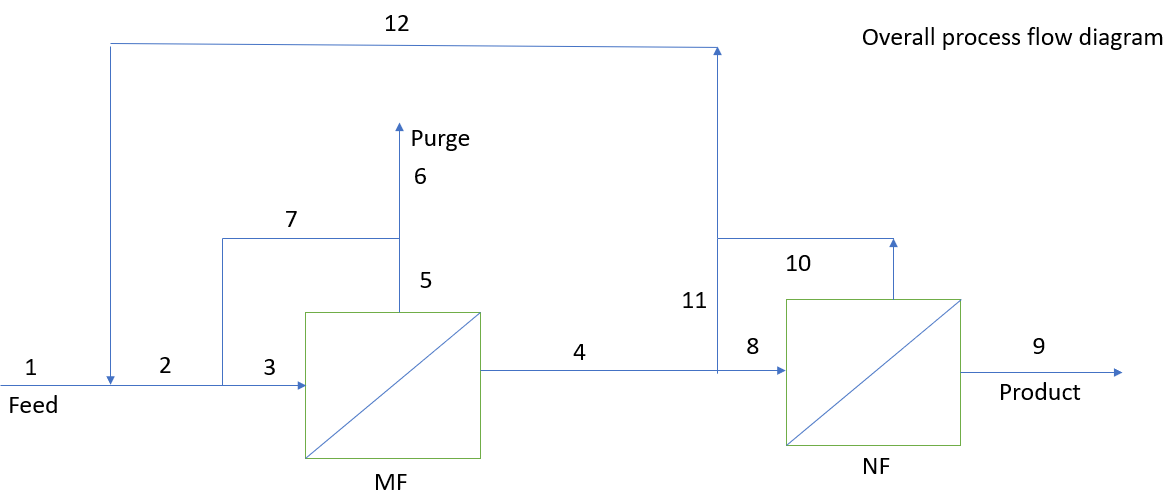

In [ ]:
#Import Packages and Libraries
import numpy as np
import math as m
import pandas as pd
import matplotlib.pyplot as plt
import scipy.optimize as optimize
from scipy.optimize import fsolve
idx = pd.IndexSlice

#Adjusts window size for Jupyter notebook to fill screen
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [ ]:
#Inputs
ID = .002  #Module inner diameter, m                                
length = 10  #Module length, m                              
numChannels = 163 #Number of channels in module                          
areaMod = numChannels*length*ID*3.14159 #Module area, m^2
eta = .00001 #Pipe roughness, m
FeedQ = (10000)/(1000*3600) #Feed to whole system flowrate, m^3/s (L/hr)  
MFflux = 17.4 #MF average flux, LMH
NFflux = 11.4 #NF average flux, LMH
gammaMF = 1000 #Desired shear rate for MF stage, 1/s
gammaNF = 2700 #Desired shear rate for NF stage, 1/s
Feed = [6.45,0.90,44.5] #Feed (S1) concentrations, g/L

diff = np.array([9.90E-10,8.4E-10,4.3E-10]) #Diffusivity coefficient, m^2/s 
vantHoff = np.array([1, 0.65, 0.03]) #Van't Hoff coefficient, dimensionless
osmo_factor = 32413810 #Osmostic factor, Pa/massfrac
P_in = (208)*6894.75729 #Inlet pressure, Pa (psi)
P_perm = (14.6959)*6894.75729 #Permeate side pressure - assumed constant atmospheric, Pa (psi)
alpha = np.array([1.62819898e-07,  3.62021670e-06,  2.24117574e-05]) #Membrane selectivites, calculated from Selectivity Optimization file, 1/Pa

In [ ]:
#Calculate rejection coefficients for NF
colsalip = ['M','xp','xr','R'] #Aliphatics concentration polarization, mass fractions, rejection coefficient
alip = pd.DataFrame(data=np.zeros((99, len(colsalip))), columns = colsalip)

colsaro = ['M','xp','xr','R'] #Aromatics concentration polarization, mass fractions, rejection coefficient
aro = pd.DataFrame(data=np.zeros((99, len(colsaro))), columns = colsaro)

colsunk = ['M','xp','xr','R'] #Unaccounted concentration polarization, mass fractions, rejection coefficient
unk = pd.DataFrame(data=np.zeros((99, len(colsunk))), columns = colsunk)

for VolRec in range(1,100,1):
    VR = VolRec
    VR_N = VR/100 #Volume recovery of NF step
    density_NF = 1033.61 + .000003667*(VR_N*100)**3.85 #NF retentate density, kg/m^3
    n_NF = 0.962 
    v_NF = (gammaNF*ID/8)*(4*n_NF/(1+3*n_NF)) #Cross sectional velocity, m/s

    #Aliphatics
    feed_c = np.array([6.2,1.2,22.3]) #Inlet to NF concentration, g/L
    feed_x0 = feed_c[0]/1029.7 #Mass fraction
    #Calculate concentration polarization coefficient
    v_w = NFflux/(density_NF*3600) #Solute velocity, m/s
    M_const0 = ((v_w**3)*length*(ID/2))/(4*v_NF*diff[0]**2)
    M_entr0 = 1.536*M_const0**(1/3)+1
    M_far0 = M_const0 + 6 - 5*np.exp(-(M_const0/3)**(1/2))
    M0 = M_entr0 #Concentration polarization coefficient
    if M_far0 < M_entr0:
        M0 = M_far0
    a0 = osmo_factor*vantHoff[0]
    alph0 = alpha[0]
    #Calculate permeate/retentate mass fractions
    def solve(xp0):
        return (xp0*(xp0*(alph0*a0 - 1)+alph0*(P_in - P_perm)+1)) - ((feed_x0-VR_N*xp0)/(1-VR_N))*(M0*(1+(alph0*a0 - 1)*xp0))
    g0 = .006
    g1 = .004
    s0 = optimize.root_scalar(solve,method = 'secant', x0 = g0, x1 = g1)
    xp0 = s0.root #Permeate mass fraction
    xr0 = (feed_x0-VR_N*xp0)/(1-VR_N) #Retentate mass fraction
    #Calculate rejection coefficient
    R0 = 1-(xp0/(2*xr0))
    alip.loc[idx[VolRec-1],idx['M']] = M0
    alip.loc[idx[VolRec-1],idx['xp']] = xp0
    alip.loc[idx[VolRec-1],idx['xr']] = xr0
    alip.loc[idx[VolRec-1],idx['R']] = R0
    
    #Aromatics
    feed_x1 = feed_c[1]/1029.7 #Mass fraction
    #Calculate concentration polarization coefficient
    v_w = NFflux/(density_NF*3600) #Solute velocity, m/s
    M_const1 = ((v_w**3)*length*(ID/2))/(4*v_NF*diff[1]**2)
    M_entr1 = 1.536*M_const1**(1/3)+1
    M_far1 = M_const1 + 6 - 5*np.exp(-(M_const1/3)**(1/2))
    M1 = M_entr1 #Concentration polarization coefficient
    if M_far1 < M_entr1:
        M1 = M_far1
    a1 = osmo_factor*vantHoff[1]
    alph1 = alpha[1]
    #Calculate permeate/retentate mass fractions
    def solve(xp1):
        return (xp1*(xp1*(alph1*a1 - 1)+alph1*(P_in - P_perm)+1)) - ((feed_x1-VR_N*xp1)/(1-VR_N))*(M1*(1+(alph1*a1 - 1)*xp1))
    g0 = .006
    g1 = .004
    s1 = optimize.root_scalar(solve,method = 'secant', x0 = g0, x1 = g1)
    xp1 = s1.root #Permeate mass fraction
    xr1 = (feed_x1-VR_N*xp1)/(1-VR_N) #Retentate mass fraction
    #Calculate rejection coefficient
    R1 = 1-(xp1/xr1)
    aro.loc[idx[VolRec-1],idx['M']] = M1
    aro.loc[idx[VolRec-1],idx['xp']] = xp1
    aro.loc[idx[VolRec-1],idx['xr']] = xr1
    aro.loc[idx[VolRec-1],idx['R']] = R1
    
    #Unaccounted
    feed_x2 = feed_c[2]/1029.7
    #Calculate concentration polarization coefficient
    v_w = NFflux/(density_NF*3600) #Solute velocity, m/s
    M_const2 = ((v_w**3)*length*(ID/2))/(4*v_NF*diff[2]**2)
    M_entr2 = 1.536*M_const2**(1/3)+1
    M_far2 = M_const2 + 6 - 5*np.exp(-(M_const2/3)**(1/2))
    M2 = M_entr2 #Concentration polarization coefficient
    if M_far2 < M_entr2:
        M2 = M_far2
    a2 = osmo_factor*vantHoff[2]
    alph2 = alpha[2]
    #Calculate permeate/retentate mass fractions
    def solve(xp2):
        return (xp2*(xp2*(alph2*a2 - 1)+alph2*(P_in - P_perm)+1)) - ((feed_x2-VR_N*xp2)/(1-VR_N))*(M2*(1+(alph2*a2 - 1)*xp2))
    g0 = .006
    g1 = .004
    s2 = optimize.root_scalar(solve,method = 'secant', x0 = g0, x1 = g1)
    xp2 = s2.root #Permeate mass fraction
    xr2 = (feed_x2-VR_N*xp2)/(1-VR_N) #Retentate mass fraction
    #Calculate rejection coefficient
    R2 = 1-(xp2/xr2)
    unk.loc[idx[VolRec-1],idx['M']] = M2
    unk.loc[idx[VolRec-1],idx['xp']] = xp2
    unk.loc[idx[VolRec-1],idx['xr']] = xr2
    unk.loc[idx[VolRec-1],idx['R']] = R2

In [ ]:
#Build dataframes for output data
colsS = ['VR_NF','S1', 'S2', 'S3', 'S4', 'S5','S6','S7','S8','S9','S10','S11','S12'] #Stream Flowrates, L/hr
dfS = pd.DataFrame(data=np.zeros((99, len(colsS))), columns = colsS)

colsE = ['Kprime NF','Kprime MF','Re_NF','Re_MF','f_NF','f_MF','Pdrop NF Pa','Pdrop MF Pa'] #Reynolds number, friction factor, pressure drops for MF and NF
colsE2 = ['VR_NF','VR_O','P NF W','P MF W','kWh/m3 NF','kWh/m3 MF'] #Energy Requirements for MF and NF
dfE = pd.DataFrame(data=np.zeros((99, len(colsE))), columns = colsE)
dfE2 = pd.DataFrame(data=np.zeros((99, len(colsE2))), columns = colsE2)

colsA = ['VR_NF','VR_O','Area NF','Area MF','Visc NF Pa s','Visc MF Pa s','Density NF kg/m3','Density MF kg/m3'] #Area, viscosity, density data for MF and NF
dfA = pd.DataFrame(data=np.zeros((99, len(colsA))), columns = colsA)

colsC = ['VR_NF','VR_O','MF Mem $/L Cer','MF Mem $/L Pol','NF Mem $/L Cer','NF Mem $/L Pol','NF Energy $/L','MF Energy $/L','Tot Energy $/L'] #All cost data for MF and NF
dfC = pd.DataFrame(data=np.zeros((99, len(colsC))), columns = colsC)

colsal = ['S1', 'S2', 'S3', 'S4', 'S5','S6','S7','S8','S9','S10','S11','S12'] #Hydroxy Concentrations, g/L
dfal = pd.DataFrame(data=np.zeros((99, len(colsal))), columns = colsal)

colsar = ['S1', 'S2', 'S3', 'S4', 'S5','S6','S7','S8','S9','S10','S11','S12'] #Aromatic Concentrations, g/L
dfar = pd.DataFrame(data=np.zeros((99, len(colsar))), columns = colsar)

colsun = ['S1', 'S2', 'S3', 'S4', 'S5','S6','S7','S8','S9','S10','S11','S12'] #Unaccounted Concentrations, g/L
dfun = pd.DataFrame(data=np.zeros((99, len(colsun))), columns = colsun)

#Begin iteration across NF VRs (1-100%)
for VolRec in range(1,100,1):
    VR = VolRec
    VR_M = 0.95 #Volume recovery of MF step
    VR_N = VR/100 #Volume recovery of NF step

#Mass balance to determine stream flowrates
    S1 = 10000 #L/hr
    def StreamSolve(S12):
        return (1-VR_N)*(VR_M*(S1+S12))-S12
    s0 = 8000
    s1 = 9000
    s = optimize.root_scalar(StreamSolve,method = 'secant', x0 = s0, x1 = s1)
    S12 = s.root
    S2 = S1+S12
    S4 = VR_M*S2
    S6 = S2-S4
    S9 = VR_N*S4
    
    VR_O = S9/S1 #Overall process volume recovery
    
    #Calculate required areas
    areaMF = S4/MFflux #Required area for MF stage, m^2
    numModMF = areaMF/areaMod #Number of modules required for MF stage
    areaNF = S9/NFflux #Required area for NF stage, m^2
    numModNF = areaNF/areaMod #Number of modules required for NF stage
    
    #Calculate density and viscosity
    #MF
    if VR_M < 0.88:
        n_MF = .962
        K_MF = 0.00001157*(VR_M*100) + 0.00151
        density_MF = 1054.73+0.000003667*(VR_M*100)**3.924 #MF retenate density, kg/m^3
    else:
        n_MF = -0.1298*(VR_M*100)+12.953 
        K_MF = 3e-50*np.exp(1.2033*(VR_M*100)) 
        density_MF = 1054.73+0.000003667*(VR_M*100)**3.924
    
    visc_MF = K_MF*gammaMF**(n_MF-1) #MF retentate viscosity, Pa s

    #NF
    n_NF = 0.962 
    K_NF = 0.00001157*(VR_N*100) + 0.00151
    density_NF = 1033.61 + .000003667*(VR_N*100)**3.85 #NF retentate density, kg/m^3
    visc_NF = K_NF*gammaNF**(n_NF-1) #NF retentate viscosity, Pa s

    #Calculate recirculation flow rates
    v_MF = (gammaMF*ID/8)*(4*n_MF/(1+3*n_MF)) #Cross sectional velocity, m/s
    Q_MF = v_MF*3.14159*(ID/2)**2 #Volumetric flow rate in a single channel, m^3/s
    TotalQ_MF = Q_MF*numChannels*numModMF #Total volumetric flow rate into the module, m^3/s
    S7 = TotalQ_MF*1000*3600 - S2 #L/hr
    S3 = TotalQ_MF*1000*3600 #L/hr
    S5 = S6 + S7 #L/hr

    v_NF = (gammaNF*ID/8)*(4*n_NF/(1+3*n_NF)) #Cross sectional velocity, m/s
    Q_NF = v_NF*3.14159*(ID/2)**2 #Volumetric flow rate in a single channel, m^3/s
    TotalQ_NF = Q_NF*numChannels*numModNF #Total volumetric flow rate into the module, m^3/s
    S11 = TotalQ_NF*1000*3600 - S4 #L/hr
    if S11 <0:
        S11 = 0
    S8 = TotalQ_NF*1000*3600 #L/hr
    S10 = S11 + S12 #L/hr
    
    #Solve for the Energy Consumption
    #MF
    K_primeMF = K_MF*((1+3*n_MF)/(4*n_MF))**n_MF
    Re_MF = (ID**n_MF*v_MF**(2-n_MF)*density_MF)/(K_primeMF*8**(n_MF-1)) #Modified Reynolds number
    
    #Solve for fanning friction factor
    def fricfactorMF(f):
        return 4*m.log10(Re_MF*f**0.5)-0.4-f**-0.5
    f0 = .005
    f1 = .01
    fricMF = optimize.root_scalar(fricfactorMF,method = 'secant', x0 = f0, x1 = f1)
    f_MF = fricMF.root #MF friction factor
    
    #Calculate pressure drop
    Pdrop_MF = f_MF*2*(density_MF)*length*v_MF**2/ID #MF pressure drop through module, Pa
    eff = 0.6 #Pump efficiency
    P_MF = (S3/(1000*3600))*Pdrop_MF/eff #Pump power required, W
    TotalP_MF = P_MF/S9 #Pump power required, kWh/m^3 of permeate

    #NF
    K_primeNF = K_NF*((1+3*n_NF)/(4*n_NF))**n_NF
    Re_NF = (ID**n_NF*v_NF**(2-n_NF)*density_NF)/(K_primeNF*8**(n_NF-1)) #Modified Reynolds number
    
    #Solve for fanning friction factor
    def fricfactorNF(f):
        return 4*m.log10(Re_NF*f**0.5)-0.4-f**-0.5
    f0 = .005
    f1 = .01
    fricNF = optimize.root_scalar(fricfactorNF,method = 'secant', x0 = f0, x1 = f1)
    f_NF = fricNF.root #NF friction factor
    
    #Calculate pressure drop
    Pdrop_NF = f_NF*2*(density_NF)*length*v_NF**2/ID #NF pressure drop through module, Pa
    eff = 0.6 #Pump efficiency
    P_NF = (S8/(1000*3600))*Pdrop_NF/eff #Pump power required, W
    TotalP_NF = P_NF/S9 #Pump power required, kWh/m^3 of permeate
    
    TotEnergy = TotalP_MF + TotalP_NF #Total energy requirement, NF + MF
    
    #Calculate energy costs
    MF_ECost = (TotalP_MF*0.072*S4/1000)/S9 #MF energy cost, $/kg
    NF_ECost = (TotalP_NF*0.072*S9/1000)/S9 #NF energy cost, $/kg
    
    #Calculate membrane costs
    CostMFCer = (150/(30*350*24))*areaMF/S9 #$/L
    CostMFPol = (500/(30*350*24))*areaMF/S9 #$/L
    CostNFCer = (150/(30*350*24))*areaNF/S9 #$/L
    CostNFPol = (500/(30*350*24))*areaNF/S9 #$/L
    
    #Calculate stream concentrations
    colsConc0 = ['C1', 'C2', 'C3', 'C4', 'C5','C6','C7','C8','C9','C10','C11','C12'] #Stream concentrations
    dfConc0 = pd.DataFrame(data=np.zeros((3, len(colsConc0))), columns = colsConc0)

    RM = [0,0,0.96] #Microfiltration rejection coefficient
    FR = [S1,S2,S3,S4,S5,S6,S7,S8,S9,S10,S11,S12]
    #Aliphatics
    RN0 = alip.loc[idx[VolRec-1],idx['R']] #Nanofiltration rejection coefficient
    F01 = [1,0,0,0,0,0,0,0,0,0,0,0]
    F02 = [-FR[0]/FR[1],1,0,0,0,0,0,0,0,0,0,-FR[11]/FR[1]]
    F03 = [0,-FR[1]/FR[2],1,0,0,0,-FR[6]/FR[2],0,0,0,0,0]
    F04 = [0,-FR[1]/(FR[3]+(FR[5]/(1-RM[0]))),0,1,0,0,0,0,0,0,0,0]
    F05 = [0,0,0,-1/(1-RM[0]),1,0,0,0,0,0,0,0]
    F06 = [0,0,0,0,1,-1,0,0,0,0,0,0]
    F07 = [0,0,0,0,0,1,-1,0,0,0,0,0]
    F08 = [0,0,0,-FR[3]/FR[8],0,0,0,1,0,0,-FR[10]/FR[7],0]
    F09 = [0,0,0,-FR[3]/(FR[8]+FR[11]/(1-RN0)),0,0,0,0,1,0,0,0]
    F010 = [0,0,0,0,0,0,0,0,-1/(1-RN0),1,0,0]
    F011 = [0,0,0,0,0,0,0,0,0,1,-1,0]
    F012 = [0,0,0,0,0,0,0,0,0,0,1,-1]
    ANS0 = [Feed[0],0,0,0,0,0,0,0,0,0,0,0]
    A0 = np.array([F01,F02,F03,F04,F05,F06,F07,F08,F09,F010,F011,F012])
    B0 = ANS0
    C0 = np.linalg.solve(A0,B0) #Solve conncentrations
    #Aromatics
    RN1 = aro.loc[idx[VolRec-1],idx['R']] #Nanofiltration rejection coefficient
    F11 = [1,0,0,0,0,0,0,0,0,0,0,0]
    F12 = [-FR[0]/FR[1],1,0,0,0,0,0,0,0,0,0,-FR[11]/FR[1]]
    F13 = [0,-FR[1]/FR[2],1,0,0,0,-FR[6]/FR[2],0,0,0,0,0]
    F14 = [0,-FR[1]/(FR[3]+(FR[5]/(1-RM[1]))),0,1,0,0,0,0,0,0,0,0]
    F15 = [0,0,0,-1/(1-RM[1]),1,0,0,0,0,0,0,0]
    F16 = [0,0,0,0,1,-1,0,0,0,0,0,0]
    F17 = [0,0,0,0,0,1,-1,0,0,0,0,0]
    F18 = [0,0,0,-FR[3]/FR[8],0,0,0,1,0,0,-FR[10]/FR[7],0]
    F19 = [0,0,0,-FR[3]/(FR[8]+FR[11]/(1-RN1)),0,0,0,0,1,0,0,0]
    F110 = [0,0,0,0,0,0,0,0,-1/(1-RN1),1,0,0]
    F111 = [0,0,0,0,0,0,0,0,0,1,-1,0]
    F112 = [0,0,0,0,0,0,0,0,0,0,1,-1]
    ANS1 = [Feed[1],0,0,0,0,0,0,0,0,0,0,0]
    A1 = np.array([F11,F12,F13,F14,F15,F16,F17,F18,F19,F110,F111,F112])
    B1 = ANS1
    C1 = np.linalg.solve(A1,B1) #Solve conncentrations
    #Unaccounted
    RN2 = unk.loc[idx[VolRec-1],idx['R']] #Nanofiltration rejection coefficient
    F21 = [1,0,0,0,0,0,0,0,0,0,0,0]
    F22 = [-FR[0]/FR[1],1,0,0,0,0,0,0,0,0,0,-FR[11]/FR[1]]
    F23 = [0,-FR[1]/FR[2],1,0,0,0,-FR[6]/FR[2],0,0,0,0,0]
    F24 = [0,-FR[1]/(FR[3]+(FR[5]/(1-RM[2]))),0,1,0,0,0,0,0,0,0,0]
    F25 = [0,0,0,-1/(1-RM[2]),1,0,0,0,0,0,0,0]
    F26 = [0,0,0,0,1,-1,0,0,0,0,0,0]
    F27 = [0,0,0,0,0,1,-1,0,0,0,0,0]
    F28 = [0,0,0,-FR[3]/FR[8],0,0,0,1,0,0,-FR[10]/FR[7],0]
    F29 = [0,0,0,-FR[3]/(FR[8]+FR[11]/(1-RN2)),0,0,0,0,1,0,0,0]
    F210 = [0,0,0,0,0,0,0,0,-1/(1-RN2),1,0,0]
    F211 = [0,0,0,0,0,0,0,0,0,1,-1,0]
    F212 = [0,0,0,0,0,0,0,0,0,0,1,-1]
    ANS2 = [Feed[2],0,0,0,0,0,0,0,0,0,0,0]
    A2 = np.array([F21,F22,F23,F24,F25,F26,F27,F28,F29,F210,F211,F212])
    B2 = ANS2
    C2 = np.linalg.solve(A2,B2) #Solve conncentrations
    
    dfal.loc[idx[VolRec-1],idx[:]] = C0
    dfar.loc[idx[VolRec-1],idx[:]] = C1
    dfun.loc[idx[VolRec-1],idx[:]] = C2
    
    dfS.loc[idx[VolRec-1],idx['VR_NF']] = VR
    dfS.loc[idx[VolRec-1],idx['S1']] = S1
    dfS.loc[idx[VolRec-1],idx['S2']] = S2
    dfS.loc[idx[VolRec-1],idx['S3']] = S3
    dfS.loc[idx[VolRec-1],idx['S4']] = S4
    dfS.loc[idx[VolRec-1],idx['S5']] = S5
    dfS.loc[idx[VolRec-1],idx['S6']] = S6
    dfS.loc[idx[VolRec-1],idx['S7']] = S7
    dfS.loc[idx[VolRec-1],idx['S8']] = S8
    dfS.loc[idx[VolRec-1],idx['S9']] = S9
    dfS.loc[idx[VolRec-1],idx['S10']] = S10
    dfS.loc[idx[VolRec-1],idx['S11']] = S11
    dfS.loc[idx[VolRec-1],idx['S12']] = S12
    
    dfE.loc[idx[VolRec-1],idx['Kprime NF']] = K_primeNF
    dfE.loc[idx[VolRec-1],idx['Kprime MF']] = K_primeMF
    dfE.loc[idx[VolRec-1],idx['Re_NF']] = Re_NF
    dfE.loc[idx[VolRec-1],idx['Re_MF']] = Re_MF
    dfE.loc[idx[VolRec-1],idx['f_NF']] = f_NF
    dfE.loc[idx[VolRec-1],idx['f_MF']] = f_MF
    dfE.loc[idx[VolRec-1],idx['Pdrop NF Pa']] = Pdrop_NF
    dfE.loc[idx[VolRec-1],idx['Pdrop MF Pa']] = Pdrop_MF
    
    dfE2.loc[idx[VolRec-1],idx['VR_NF']] = VR
    dfE2.loc[idx[VolRec-1],idx['VR_O']] = VR_O*100
    dfE2.loc[idx[VolRec-1],idx['P NF W']] = P_NF
    dfE2.loc[idx[VolRec-1],idx['P MF W']] = P_MF
    dfE2.loc[idx[VolRec-1],idx['kWh/m3 NF']] = TotalP_NF
    dfE2.loc[idx[VolRec-1],idx['kWh/m3 MF']] = TotalP_MF
    
    dfA.loc[idx[VolRec-1],idx['VR_NF']] = VR
    dfA.loc[idx[VolRec-1],idx['VR_O']] = VR_O*100
    dfA.loc[idx[VolRec-1],idx['Area NF']] = areaNF
    dfA.loc[idx[VolRec-1],idx['Area MF']] = areaMF
    dfA.loc[idx[VolRec-1],idx['Visc NF Pa s']] = visc_NF
    dfA.loc[idx[VolRec-1],idx['Visc MF Pa s']] = visc_MF
    dfA.loc[idx[VolRec-1],idx['Density NF kg/m3']] = density_NF
    dfA.loc[idx[VolRec-1],idx['Density MF kg/m3']] = density_MF
    
    dfC.loc[idx[VolRec-1],idx['VR_NF']] = VR
    dfC.loc[idx[VolRec-1],idx['VR_O']] = VR_O*100
    dfC.loc[idx[VolRec-1],idx['MF Mem $/L Cer']] = CostMFCer
    dfC.loc[idx[VolRec-1],idx['MF Mem $/L Pol']] = CostMFPol
    dfC.loc[idx[VolRec-1],idx['NF Mem $/L Cer']] = CostNFCer
    dfC.loc[idx[VolRec-1],idx['NF Mem $/L Pol']] = CostMFPol
    dfC.loc[idx[VolRec-1],idx['NF Energy $/L']] = NF_ECost
    dfC.loc[idx[VolRec-1],idx['MF Energy $/L']] = MF_ECost
    dfC.loc[idx[VolRec-1],idx['Tot Energy $/L']] = NF_ECost + MF_ECost

In [ ]:
#Plot results
fig, ((fig1, fig2),(fig3, fig4)) = plt.subplots(2,2,sharey=False,figsize=(13,13))

fig1.plot(dfE2.loc[idx[:],idx['VR_O']],dfE2.loc[idx[:],idx['kWh/m3 MF']], label = 'MF' )
fig1.plot(dfE2.loc[idx[:],idx['VR_O']],dfE2.loc[idx[:],idx['kWh/m3 NF']],color = 'orange', label = 'NF' )
fig1.legend(fontsize=10)
fig1.set_xlabel('Overall Recovery (%)')
fig1.set_ylabel('kWh $ m^{-3} $')
fig1.set_title('Energy Requirement')

fig2.plot(dfA.loc[idx[:],idx['VR_O']],dfA.loc[idx[:],idx['Area MF']], label = 'MF')
fig2.plot(dfA.loc[idx[:],idx['VR_O']],dfA.loc[idx[:],idx['Area NF']], label = 'NF')
fig2.legend(fontsize=10)
fig2.set_xlabel('Overall Recovery (%)')
fig2.set_ylabel('$ m^{2} $')
fig2.set_title(' Required Membrane Area')

fig3.plot(dfC.loc[idx[7:],idx['VR_O']],dfC.loc[idx[7:],idx['MF Energy $/L']], label = 'MF')
fig3.plot(dfC.loc[idx[7:],idx['VR_O']],dfC.loc[idx[7:],idx['NF Energy $/L']], label = 'NF')
fig3.plot(dfC.loc[idx[7:],idx['VR_O']],dfC.loc[idx[7:],idx['Tot Energy $/L']], label = 'Total')
fig3.set_xlabel('Overall Recovery (%)')
fig3.legend(fontsize=10)
fig3.set_ylabel('$/L')
fig3.set_title('Energy Cost')

fig4.plot(dfC.loc[idx[:],idx['VR_O']],dfC.loc[idx[:],idx['MF Mem $/L Cer']], label = ' MF Ceramic')
fig4.plot(dfC.loc[idx[:],idx['VR_O']],dfC.loc[idx[:],idx['NF Mem $/L Cer']],color = 'orange', label = 'NF Ceramic')
fig4.set_xlabel('Overall Recovery (%)')
fig4.set_ylabel('$/L')
fig4.set_title('Membrane Cost')
fig4.legend(fontsize=10)